In [ ]:
"""
Taken from https://github.com/owkin/HistoSSLscaling
"""

In [1]:
from typing import List, Optional
import torch
from torch import nn
from models.utils.attention import GatedAttention
from models.utils.mlp import MLP
from models.utils.tile_layers import TilesMLP

In [2]:
class PE(nn.Module):
    def __init__(
        self,
        in_features: int,
        out_features: int = 1,
        d_model_attention: int = 128,
        temperature: float = 1.0,
        tiles_mlp_hidden: Optional[List[int]] = None,
        mlp_hidden: Optional[List[int]] = None,
        mlp_dropout: Optional[List[float]] = None,
        mlp_activation: Optional[torch.nn.Module] = torch.nn.Sigmoid(),
        bias: bool = True,
        metadata_cols: int = 3,
    ) -> None:
        super(PE, self).__init__()

        if mlp_dropout is not None:
            if mlp_hidden is not None:
                assert len(mlp_hidden) == len(
                    mlp_dropout
                ), "mlp_hidden and mlp_dropout must have the same length"
            else:
                raise ValueError(
                    "mlp_hidden must have a value and have the same length"
                    "as mlp_dropout if mlp_dropout is given."
                )

        self.tiles_emb = TilesMLP(
            in_features,
            hidden=tiles_mlp_hidden,
            bias=bias,
            out_features=d_model_attention,
        )

        self.attention_layer = GatedAttention(
            d_model=d_model_attention, temperature=temperature
        )

        mlp_in_features = d_model_attention

        self.mlp = MLP(
            in_features=mlp_in_features,
            out_features=out_features,
            hidden=mlp_hidden,
            dropout=mlp_dropout,
            activation=mlp_activation,
        )

        self.metadata_cols = metadata_cols

    def score_model(
        self, x: torch.Tensor, mask: Optional[torch.BoolTensor] = None
    ) -> torch.Tensor:
        """Get attention logits.

        Parameters
        ----------
        x: torch.Tensor
            (B, N_TILES, FEATURES)
        mask: Optional[torch.BoolTensor]
            (B, N_TILES, 1), True for values that were padded.

        Returns
        -------
        attention_logits: torch.Tensor
            (B, N_TILES, 1)
        """
        tiles_emb = self.tiles_emb(x, mask)
        attention_logits = self.attention_layer.attention(tiles_emb, mask)
        return attention_logits

    def forward(
        self, features: torch.Tensor, mask: Optional[torch.BoolTensor] = None
    ) -> torch.Tensor:
        """
        Parameters
        ----------
        features: torch.Tensor
            (B, N_TILES, D+3)
        mask: Optional[torch.BoolTensor]
            (B, N_TILES, 1), True for values that were padded.

        Returns
        -------
        logits, attention_weights: Tuple[torch.Tensor, torch.Tensor]
            (B, OUT_FEATURES), (B, N_TILES)
        """
        tiles_emb = self.tiles_emb(features[..., self.metadata_cols :], mask)
        scaled_tiles_emb, _ = self.attention_layer(tiles_emb, mask)
        logits = self.mlp(scaled_tiles_emb)

        return logits

In [3]:
if __name__ == "__main__":
    # in thesis/code
    d_embed = 128
    d_out = 1  # binary classification
    d_attn = 128  # attention mechanism dim
    # I will need to change this according to the feature extractor's output 
    # what about dropout rate or hidden layers? 
    
    model = PE(
        in_features=d_embed,
        out_features=d_out,
        d_model_attention=d_attn,
        temperature=1.0,  # temperature for the softmax in the attention layer
        tiles_mlp_hidden=[64, 32],  # hidden layers for the TilesMLP
        mlp_hidden=[32, 16],  # hidden layers for the final MLP
        mlp_dropout=[0.25, 0.1],  # dropout rates for the final MLP
        mlp_activation=torch.nn.ReLU(),  # activation function for the final MLP
        bias=True,  # use bias in MLP layers
        metadata_cols=3,  # number of metadata columns
    )
    features = torch.randn(3, 5, 131)

    mask = torch.tensor(
        [
            [False, False, True, True, True],
            [False, False, False, True, True],
            [False, False, False, False, True],
        ]
    ).unsqueeze(-1)
    logits = model(features, mask=mask)
    print("Logits:", logits)

Logits: tensor([[-0.0771],
        [-0.0754],
        [-0.0785]], grad_fn=<AddmmBackward0>)


In [ ]:
module = PE(in_features=128, out_features=1)
logits, attention_scores = module(slide, mask=mask)
# how is slide supposed to look like? 
attention_scores = module.score_model(slide, mask=mask)

In [4]:
import torch
from torch.utils.data import Dataset
from pathlib import Path
import pandas as pd

class IdilSet(Dataset):
    def __init__(self, root_dir: str, label_file: str, n_features: int = 500):
        super().__init__()
        self.n_features = n_features
        self.root_dir = root_dir
        self.labels = self.load_labels(label_file)
        self.init_files_and_labels()

    def load_labels(self, label_file):
        """Load labels from a CSV file into a dictionary."""
        df = pd.read_csv(label_file)
        # Assuming your CSV columns are named 'Sample_ID' and 'Recurrence'
        return {f"{row['Sample.ID']}.pt": int(row['Recurrence']) for index, row in df.iterrows()}

    def init_files_and_labels(self):
        """Index the .pt files and match with labels."""
        self.file_paths = []
        all_files = Path(self.root_dir).glob('*.pt')
        for file in all_files:
            file_name = str(file.name)
            if file_name in self.labels:
                self.file_paths.append(str(file))
        self.file_paths.sort()

    def __getitem__(self, idx):
        """Loads the features from file and applies padding."""
        path = self.file_paths[idx]
        # device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
        # features = torch.load(path, map_location=torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"))
        features = torch.load(path, map_location=torch.device("cpu"))
        num_actual_features = features.shape[0]
        mask = torch.zeros(self.n_features, dtype=torch.bool)
        if num_actual_features < self.n_features:
            padded_features = torch.zeros(self.n_features, features.shape[1])
            padded_features[:num_actual_features] = features
            features = padded_features
            mask[num_actual_features:] = True
        elif num_actual_features > self.n_features:
            features = features[:self.n_features]
        mask = mask.reshape(-1, 1)
        
        label = self.labels[path.split('/')[-1]]  # Get the filename and use it to find the label
        return label, features, mask

    def __len__(self):
        return len(self.file_paths)

# Example usage:
# Replace the paths with your actual file locations
dataset = IdilSet(root_dir='/n/data2/hms/dbmi/kyu/lab/idu675/Melanoma_MGB/MGB_all', label_file='/n/data2/hms/dbmi/kyu/lab/idu675/Melanoma_MGB/patient_outcomes/MGBD_cohort_319vs82_5years_July222024_modified.csv')
# path for the AUS dataset : 
#dataset = IdilSet(root_dir='/n/data2/hms/dbmi/kyu/lab/idu675/Melanoma_AUS/CHIEF_features', label_file='/n/data2/hms/dbmi/kyu/lab/idu675/Melanoma_AUS/training_labels.csv')
# /n/data2/hms/dbmi/kyu/lab/idu675/Melanoma_AUS/CHIEF_features


  0%|                                                    | 0/26 [00:00<?, ?it/s]/tmp/ipykernel_8959/1543065625.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features 

Processed 401 samples.
Labels count: 401, Predictions count: 401
Epoch [1/10], Loss: 0.1140, AUC: 0.5134, F1: 0.4831, Balanced Accuracy: 0.5134


  0%|                                                    | 0/26 [00:00<?, ?it/s]/tmp/ipykernel_8959/1543065625.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features 

Processed 401 samples.
Labels count: 401, Predictions count: 401
Epoch [2/10], Loss: 0.3363, AUC: 0.5242, F1: 0.4980, Balanced Accuracy: 0.5242


  0%|                                                    | 0/26 [00:00<?, ?it/s]/tmp/ipykernel_8959/1543065625.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features 

Processed 401 samples.
Labels count: 401, Predictions count: 401
Epoch [3/10], Loss: 0.2586, AUC: 0.5606, F1: 0.5619, Balanced Accuracy: 0.5606


  0%|                                                    | 0/26 [00:00<?, ?it/s]/tmp/ipykernel_8959/1543065625.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features 

Processed 401 samples.
Labels count: 401, Predictions count: 401
Epoch [4/10], Loss: 0.0674, AUC: 0.6488, F1: 0.6757, Balanced Accuracy: 0.6488


  0%|                                                    | 0/26 [00:00<?, ?it/s]/tmp/ipykernel_8959/1543065625.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features 

Processed 401 samples.
Labels count: 401, Predictions count: 401
Epoch [5/10], Loss: 0.5660, AUC: 0.6824, F1: 0.7147, Balanced Accuracy: 0.6824


  0%|                                                    | 0/26 [00:00<?, ?it/s]/tmp/ipykernel_8959/1543065625.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features 

Processed 401 samples.
Labels count: 401, Predictions count: 401
Epoch [6/10], Loss: 0.1702, AUC: 0.7019, F1: 0.7259, Balanced Accuracy: 0.7019


  0%|                                                    | 0/26 [00:00<?, ?it/s]/tmp/ipykernel_8959/1543065625.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features 

Processed 401 samples.
Labels count: 401, Predictions count: 401
Epoch [7/10], Loss: 0.2288, AUC: 0.7096, F1: 0.7346, Balanced Accuracy: 0.7096


  0%|                                                    | 0/26 [00:00<?, ?it/s]/tmp/ipykernel_8959/1543065625.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features 

Processed 401 samples.
Labels count: 401, Predictions count: 401
Epoch [8/10], Loss: 0.0568, AUC: 0.7159, F1: 0.7462, Balanced Accuracy: 0.7159


  0%|                                                    | 0/26 [00:00<?, ?it/s]/tmp/ipykernel_8959/1543065625.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features 

Processed 401 samples.
Labels count: 401, Predictions count: 401
Epoch [9/10], Loss: 0.3134, AUC: 0.7099, F1: 0.7460, Balanced Accuracy: 0.7099


  0%|                                                    | 0/26 [00:00<?, ?it/s]/tmp/ipykernel_8959/1543065625.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features 

Processed 401 samples.
Labels count: 401, Predictions count: 401
Epoch [10/10], Loss: 0.0249, AUC: 0.7735, F1: 0.7889, Balanced Accuracy: 0.7735


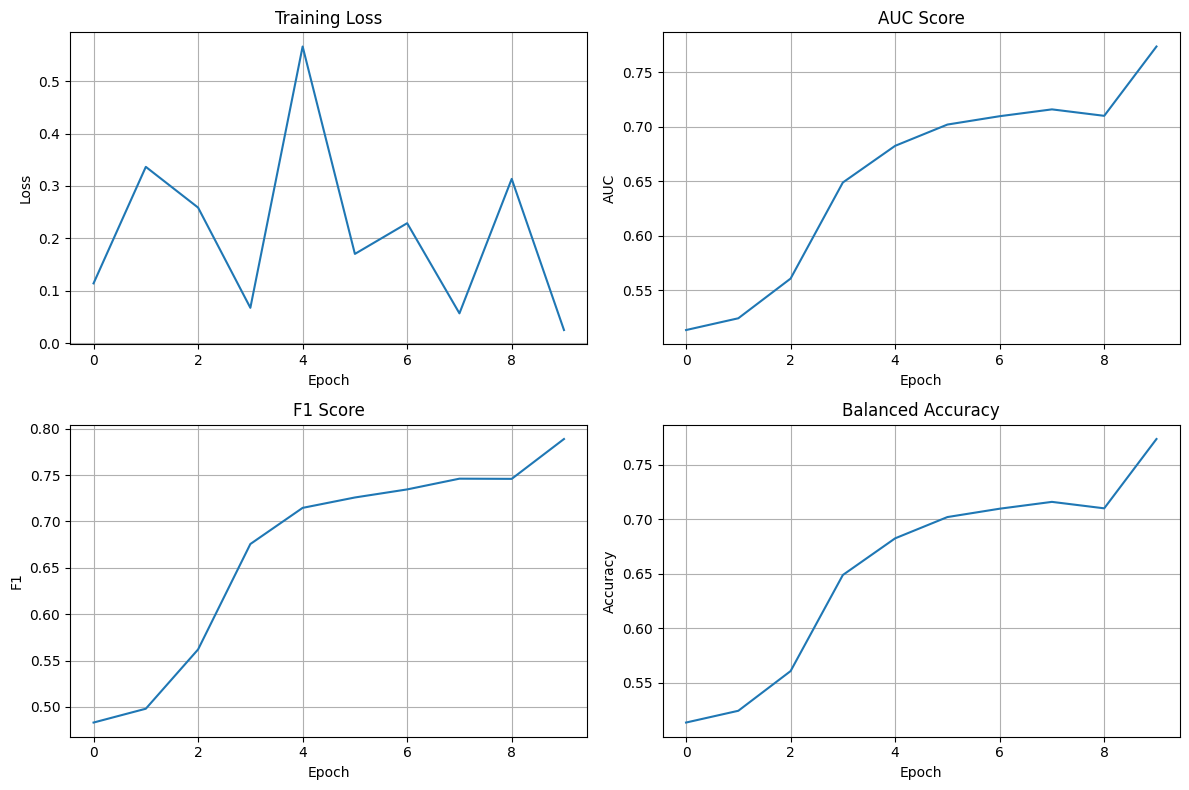

Training finished!


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_auc_score, f1_score, balanced_accuracy_score

# do a hyperparam search on the batch size, number of features, learning rate, etc

B = 16  # batch size
N = 500 # number of features per slide
D = 768 # feature dim
C = 2   # number of classes
model = PE(in_features=D, out_features=C, metadata_cols=0)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)
# watch out the learning rate 
dataloader = DataLoader(dataset, batch_size=B, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)

# Initialize lists to store metrics
epoch_losses = []
epoch_auc_scores = []
epoch_f1_scores = []
epoch_balanced_accuracies = []

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    all_labels = []
    all_preds = []
    total_samples = 0  # For debugging, to count total processed samples

    for labels, features, mask in tqdm(dataloader):
        features = features.to(device)
        mask = mask.to(device)
        labels = labels.to(device)

        logits = model(features, mask)
        predictions = torch.argmax(logits, dim=1).detach().cpu().numpy()

        # Collect labels and predictions
        all_labels.append(labels.cpu().numpy())
        all_preds.append(predictions)

        # Compute loss
        loss = criterion(logits, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Count samples
        total_samples += labels.size(0)

    print(f"Processed {total_samples} samples.")  # Debug output

    # Concatenate all collected labels and predictions
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)

    print(f"Labels count: {len(all_labels)}, Predictions count: {len(all_preds)}")  # Debug output

    # Calculate metrics
    auc_score = roc_auc_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    epoch_losses.append(loss.item())
    epoch_auc_scores.append(auc_score)
    epoch_f1_scores.append(f1)
    epoch_balanced_accuracies.append(balanced_acc)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, AUC: {auc_score:.4f}, F1: {f1:.4f}, Balanced Accuracy: {balanced_acc:.4f}")

plt.figure(figsize=(12, 8))
# Loss Plot
plt.subplot(2, 2, 1)
plt.plot(epoch_losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# AUC Score Plot
plt.subplot(2, 2, 2)
plt.plot(epoch_auc_scores, label='AUC Score')
plt.title('AUC Score')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.grid(True)

# F1 Score Plot
plt.subplot(2, 2, 3)
plt.plot(epoch_f1_scores, label='F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.grid(True)

# Balanced Accuracy Plot
plt.subplot(2, 2, 4)
plt.plot(epoch_balanced_accuracies, label='Balanced Accuracy')
plt.title('Balanced Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()
print("Training finished!")